In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'theme3_tss',
        root = '..'
    )

In [3]:
import numpy as np
import pandas as pd
import pyranges as pr
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df_abundance = pd.read_csv(snakemake.input['abundance'], sep='\t').set_index('annot_transcript_id')
samples = df_abundance.columns[11:]

transcript_tpm_filter = 1

tpm = df_abundance[samples].div(df_abundance[samples].sum(axis=0) / 1_000_000, axis=1)
df_abundance = df_abundance[(tpm >= transcript_tpm_filter).any(axis=1)]

expressed_genes = set(df_abundance['annot_gene_id'])
expressed_transcripts = set(df_abundance.index)

In [5]:
gr_gtf = pr.read_gtf(snakemake.input['gtf'])
protein_coding_genes = set(gr_gtf[gr_gtf.gene_type == 'protein_coding'].gene_id)

genes_white_list = protein_coding_genes & expressed_genes

In [6]:
gr_gtf = gr_gtf[gr_gtf.gene_id.isin(genes_white_list)]

In [7]:
gr_fantom = pr.read_bed(snakemake.input['fantom'])

In [8]:
gr_gtf_uncor = pr.read_gtf(snakemake.input['gtf_talon'])
gr_gtf_uncor = gr_gtf_uncor[gr_gtf_uncor.gene_id.isin(genes_white_list)]

In [9]:
gr_gtf_cor = pr.read_gtf(snakemake.input['gtf_talon_corrected'])
gr_gtf_cor = gr_gtf_cor[gr_gtf_cor.gene_id.isin(genes_white_list)]

In [10]:
df_abundance = pd.read_csv(snakemake.input['abundance'], sep='\t')

gr_cres_promotor = pr.read_bed(snakemake.input['ccres_promotors'])
gr_cres_proximal = pr.read_bed(snakemake.input['ccres_proximal_enhancers'])
gr_cres_distal = pr.read_bed(snakemake.input['ccres_distal_enhancers'])

In [11]:
gr_gtf_tss = gr_gtf.features.tss().drop_duplicate_positions()
# pr_gtf_tss = pr_gtf_tss[pr_gtf_tss.transcript_id.isin(transcripts)]

#gr_uncor_tss = gr_gtf_uncor.features.tss()
#gr_uncor_tss = gr_uncor_tss[gr_uncor_tss.transcript_id.isin(expressed_transcripts)]
#gr_uncor_tss = gr_uncor_tss.drop_duplicate_positions()

gr_cor_tss = gr_gtf_cor.features.tss()
gr_cor_tss = gr_cor_tss[gr_cor_tss.transcript_id.isin(expressed_transcripts)]
gr_cor_tss = gr_cor_tss.drop_duplicate_positions()

## Total Number of TSS

In [118]:
def hist_n_plus(values, n):
    hist = values.groupby(values).count()
    hist_top_n = hist[hist.index < n]
    hist_top_n[f'{n}+'] = hist[hist.index >= n].sum()
    return hist_top_n

In [119]:
num_tss_per_gene = gr_cor_tss.df.groupby('gene_id').size()

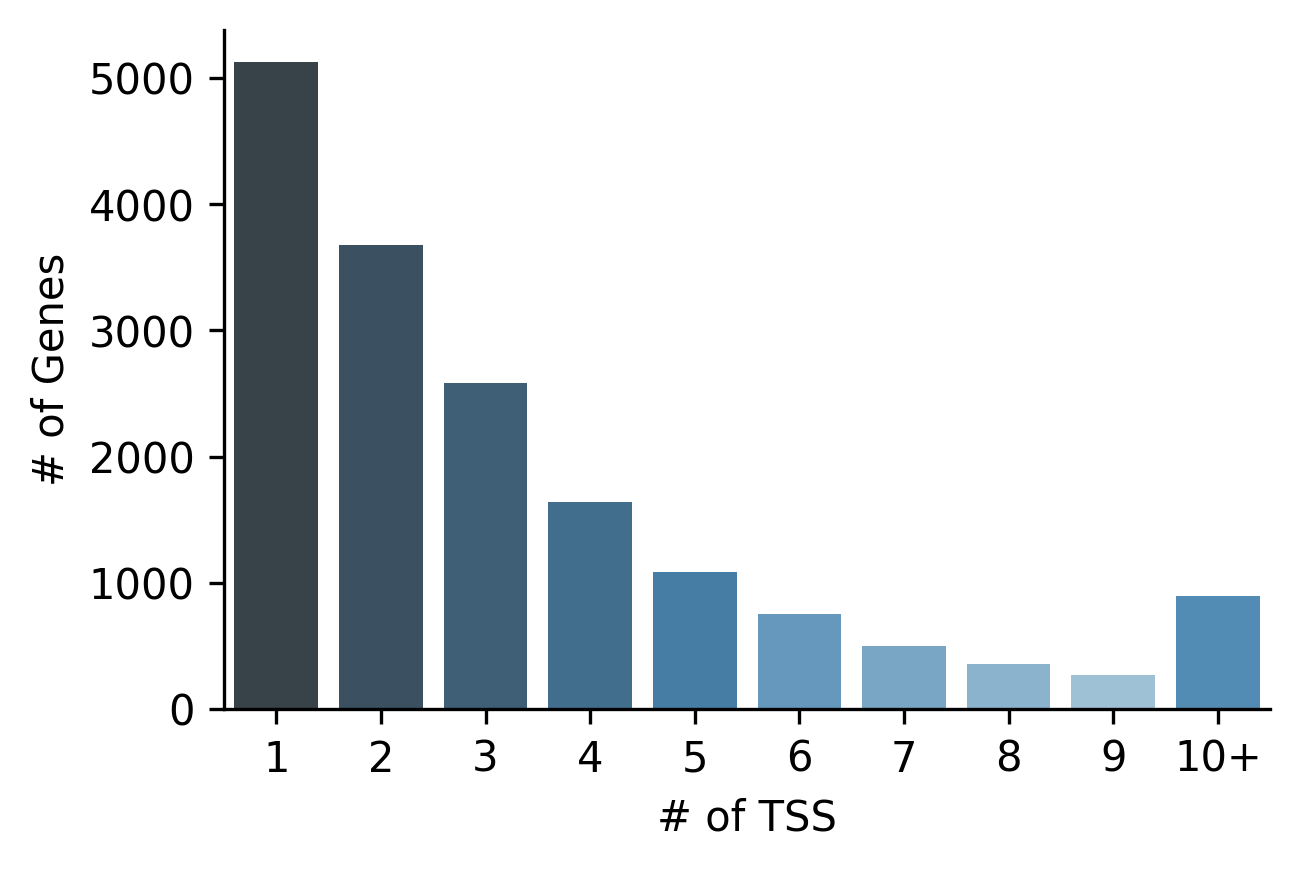

In [120]:
plt.figure(figsize=(4.5, 3), dpi=300)

hist_tss_per_gene = hist_n_plus(num_tss_per_gene, 10).reset_index()

pal = sns.color_palette("Blues_d", len(hist_tss_per_gene['index']))
rank = hist_tss_per_gene[0].argsort().argsort()

sns.barplot(data=hist_tss_per_gene, 
            x='index', y=0, palette=np.array(pal)[rank])

plt.xlabel('# of TSS')
plt.ylabel('# of Genes')
ax.legend()
sns.despine()

In [122]:
df_cor_tss = gr_gtf_cor.features.tss().df
df_cor_tss = df_cor_tss[df_cor_tss.transcript_id.isin(expressed_transcripts)]

df_cor_tss['tss_site'] = (df_cor_tss['Chromosome'].astype('str') 
                          + ':' + df_cor_tss['Start'].astype('str')
                          + ':' + df_cor_tss['Strand'].astype('str'))

In [123]:
count_tss = df_cor_tss.set_index('transcript_id').join(
    df_abundance.set_index('annot_transcript_id')[samples]).groupby(['tss_site', 'gene_id']).sum()[samples]

/tmp/ipykernel_15050/2262001061.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  median_gene_tss = df_num_tss_per_gene.median()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


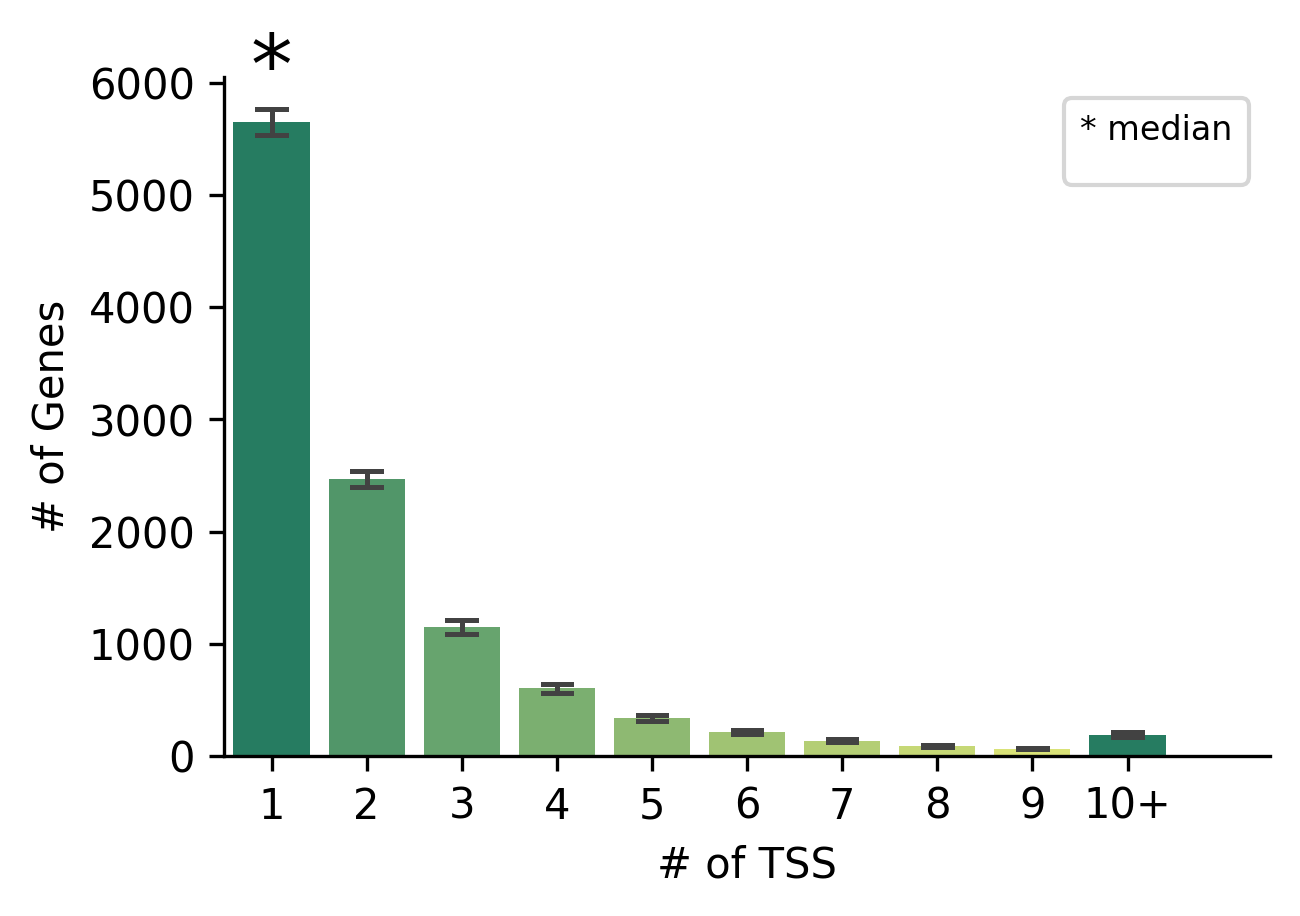

In [124]:
from matplotlib.patches import Patch

df_num_tss_per_gene = (count_tss > 0).groupby(level='gene_id').sum() \
    .melt(var_name='tissue', value_name='# of TSS')
df_num_tss_per_gene = df_num_tss_per_gene[df_num_tss_per_gene['# of TSS'] > 0]

median_gene_tss = df_num_tss_per_gene.median()
_df_num_tss_per_gene = df_num_tss_per_gene.groupby(['tissue', '# of TSS']).size().to_frame().reset_index()

plt.figure(figsize=(4.5, 3), dpi=300)

_df = _df_num_tss_per_gene[_df_num_tss_per_gene['# of TSS'] >= 10].groupby('tissue').sum()
_df['# of TSS'] = '10+'
_df_num_tss_per_gene = pd.concat([
    _df_num_tss_per_gene[_df_num_tss_per_gene['# of TSS'] < 10],
    _df
])
_df_num_tss_per_gene['# of TSS'] = _df_num_tss_per_gene['# of TSS'].astype('str')

labels = sorted(_df_num_tss_per_gene['# of TSS'].unique())
pal = sns.color_palette("summer", len(labels))
palette = _df_num_tss_per_gene['# of TSS'].map(dict(zip(labels, pal)))

ax = sns.barplot(data=_df_num_tss_per_gene, x='# of TSS', y=0, palette=palette, capsize=.3, errwidth=1.2)

p = ax.patches[int(median_gene_tss[0] - 1)]
text = plt.text(p.get_width() - 1.02, p.get_height() + 250, '*', fontsize=20, label='median')

plt.xlim((-0.5, 10.5))
plt.ylabel('# of Genes')

leg = ax.legend()
leg.set_title('* median', prop={'size': 8})
sns.despine()

## Overlap of TSS with Gencode

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:33<00:00,  6.73s/it]


,# of TSS,Distance,Annotation,percentage
0,3749,<1,GENCODE,2%
1,6783,<1,ENCODE,11%
2,20082,<10,GENCODE,15%
3,14337,<10,ENCODE,24%
4,52606,<50,GENCODE,41%
5,23961,<50,ENCODE,40%
6,65456,<100,GENCODE,51%
7,27888,<100,ENCODE,47%
8,88022,<500,GENCODE,68%
9,37651,<500,ENCODE,64%


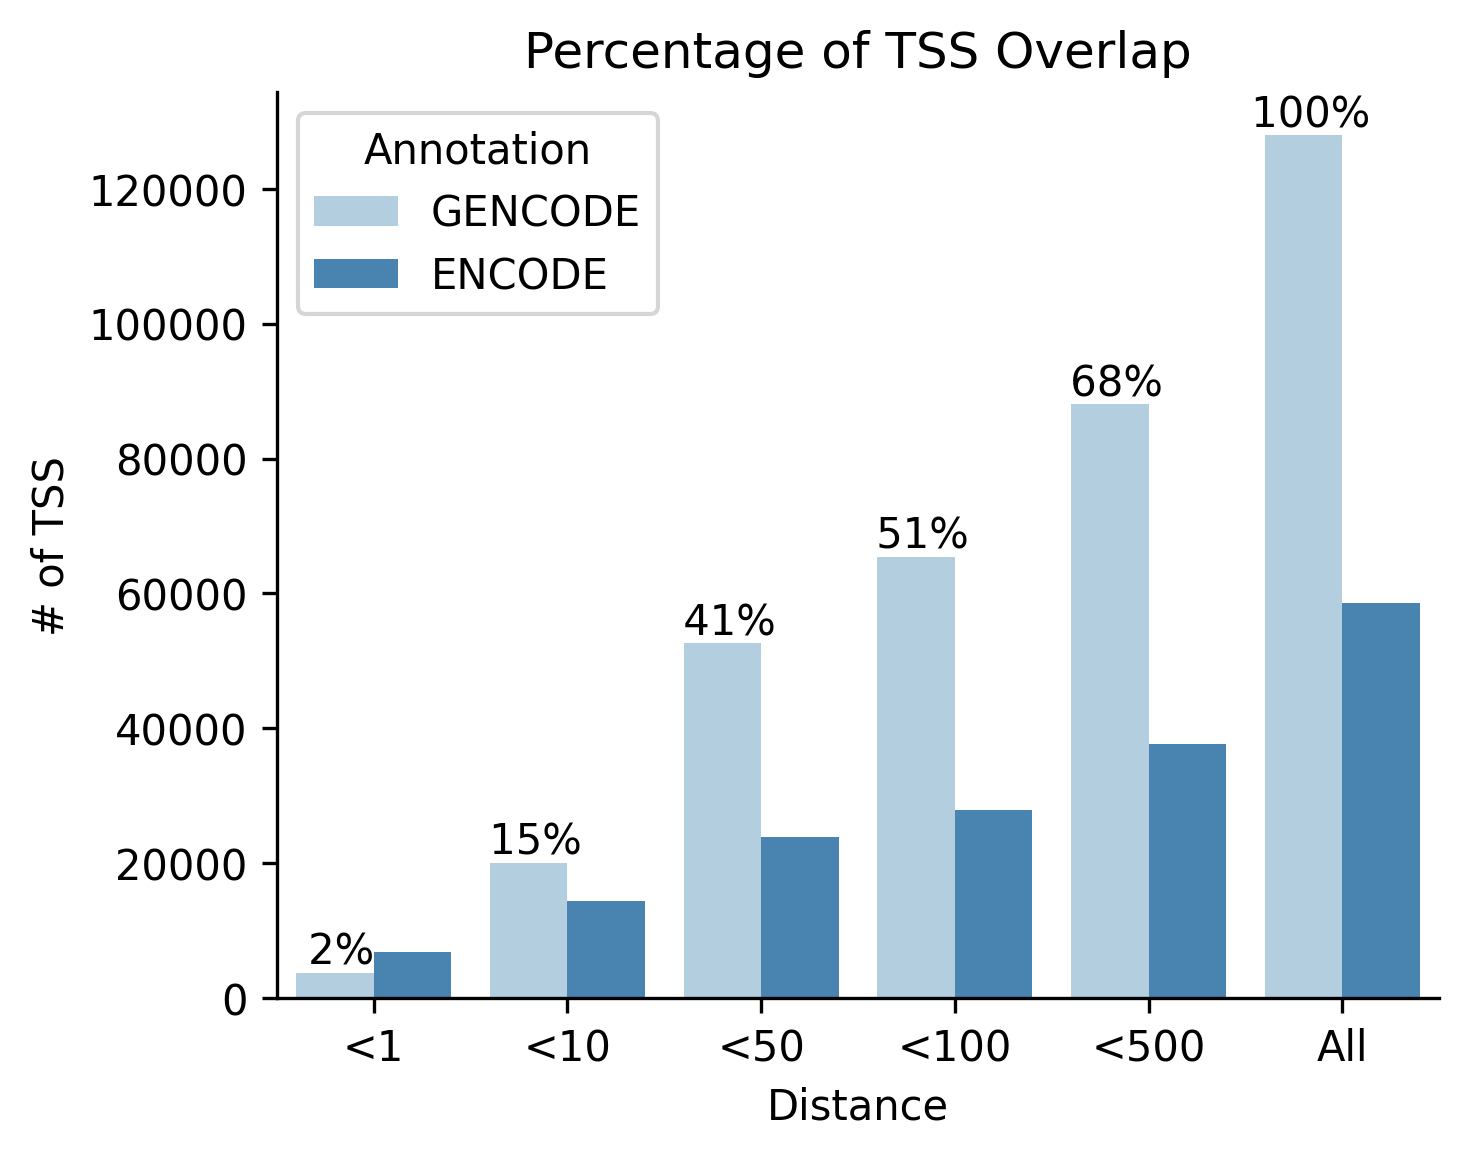

In [126]:
tss_distance_cutoff = 100

_df = list()

for i in tqdm([1, 10, 50, 100, 500]):
    num = (gr_gtf_tss.nearest(gr_cor_tss).Distance < i).sum()
    _df.append({
        '# of TSS': num,
        'Distance': f'<{i}',
        'Annotation': 'GENCODE',
        'percentage': f' {int(num * 100 / len(gr_gtf_tss))}%'
    })
    num = (gr_cor_tss.nearest(gr_gtf_tss).Distance <= i).sum()
    _df.append({
        '# of TSS': num,
        'Distance': f'<{i}',
        'Annotation': 'ENCODE',
        'percentage': f'  {int(num * 100 / len(gr_cor_tss))}%'
    })
    
num =  len(gr_gtf_tss)
_df.append({
    '# of TSS': num,
    'Distance': 'All',
    'Annotation': 'GENCODE',
    'percentage': f' {int(num * 100 / len(gr_gtf_tss))}%'
})

num = len(gr_cor_tss)
_df.append({
    '# of TSS': num,
    'Distance': 'All',
    'Annotation': 'ENCODE',
    'percentage': f'   {int(num * 100 / len(gr_cor_tss))}%'
})

_df = pd.DataFrame(_df)

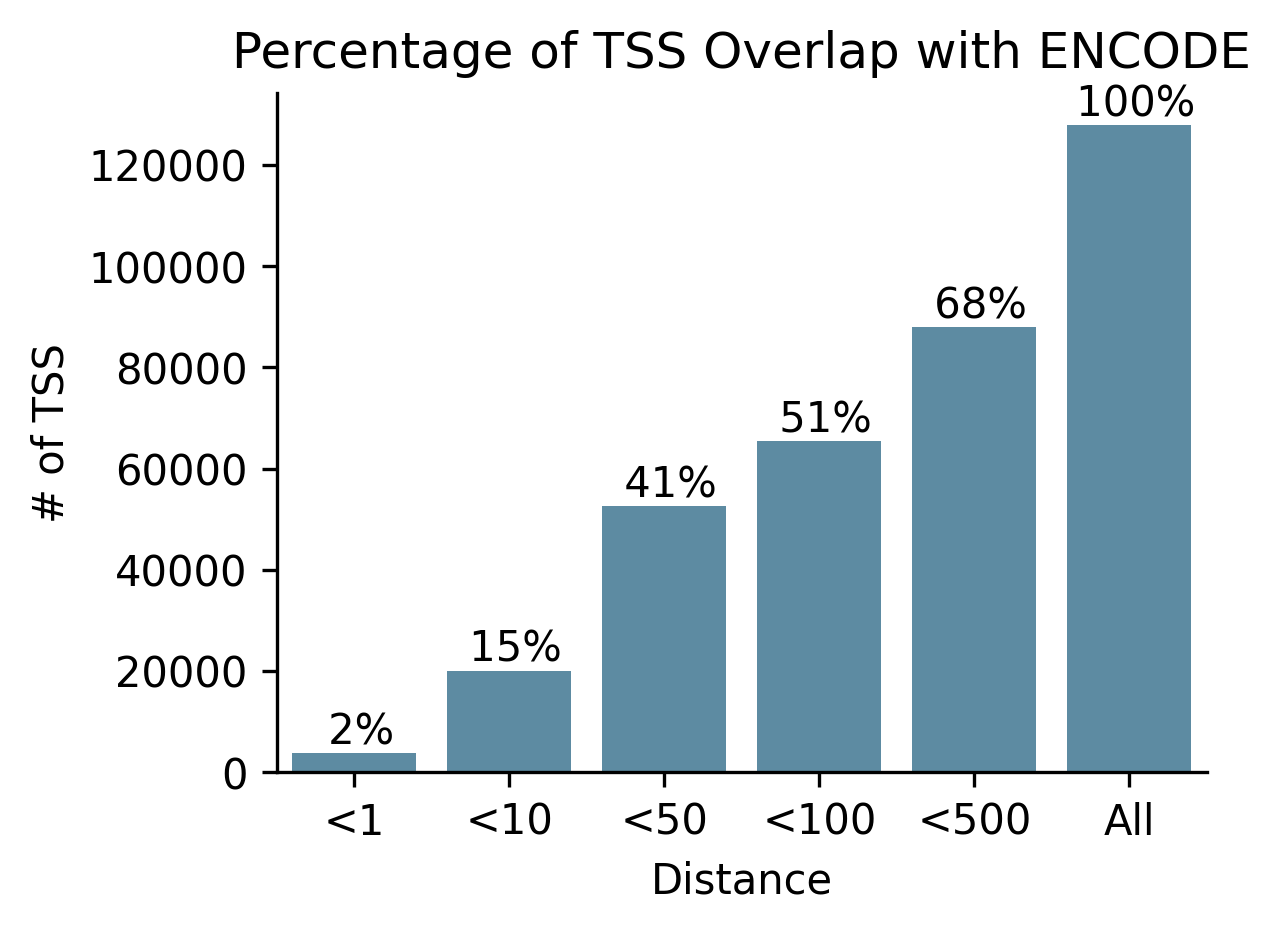

In [149]:
plt.figure(figsize=(4, 3), dpi=300)

plt.title('Percentage of TSS Overlap with ENCODE')
ax = sns.barplot(data=_df[_df['Annotation'] == 'GENCODE'], x='Distance', y='# of TSS', palette=['#528fad'])
ax.bar_label(ax.containers[0], labels=_df[_df['Annotation'] == 'GENCODE']['percentage'])
sns.despine()

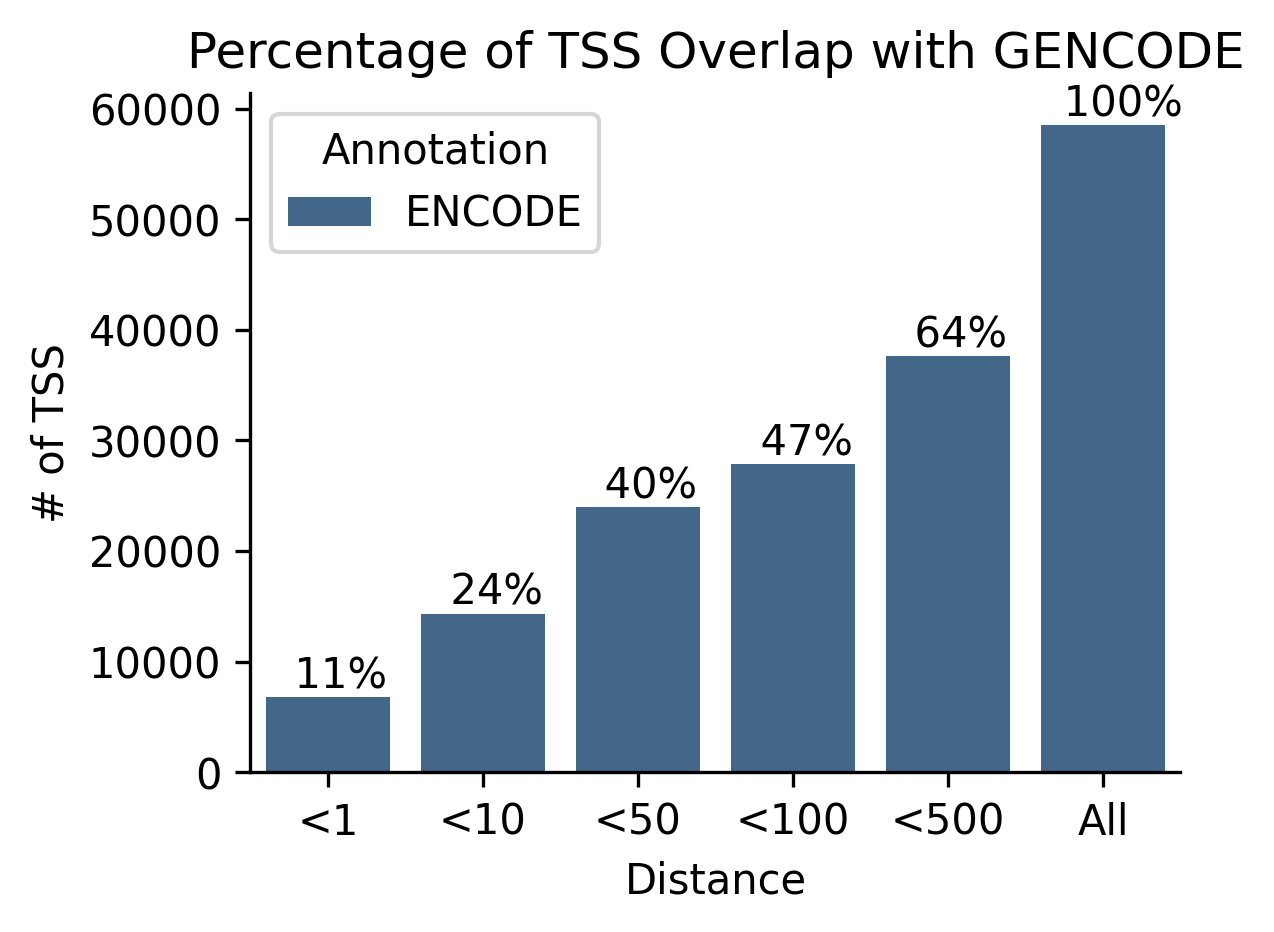

In [150]:
plt.figure(figsize=(4, 3), dpi=300)

plt.title('Percentage of TSS Overlap with GENCODE')
ax = sns.barplot(data=_df[_df['Annotation'] == 'ENCODE'], x='Distance', y='# of TSS', 
                 hue='Annotation', palette=['#376795'])
ax.bar_label(ax.containers[0], labels=_df[_df['Annotation'] == 'ENCODE']['percentage'])
sns.despine()

## Overlap cCRS and fantom5

In [16]:
def nearest_cCREs(gr, dist):    
    ccres = [
        ('promoter', gr_cres_promotor),
        ('proximal enhancer', gr_cres_proximal),
        ('distal enhancer', gr_cres_distal)        
    ]
    
    overlap = dict()
    
    for label, gr_ccres in ccres:
        _gr = gr.nearest(gr_ccres)
        overlap[label] = _gr[_gr.Distance < dist]
        _gr = _gr[_gr.Distance >= dist]

    return overlap

def nearest_fantom(gr, dist=100):
    _gr = gr.nearest(gr_fantom)
    
    if dist is not None:
        _gr = _gr[_gr.Distance < dist]

    return _gr

In [100]:
df = list()

tpm_filters = [0, 1, 5, 10, 25, 50, 100]
tpm_filters = list(zip(tpm_filters, tpm_filters[1:]))

_transcript_tpm = (tpm.sum(axis=1) / (tpm.sum().sum() / 1_000_000))

for lower, upper in tqdm(tpm_filters):
    _transcripts = _transcript_tpm[(upper > _transcript_tpm) & (_transcript_tpm >= lower)].index

    _gr = gr_cor_tss[gr_cor_tss.transcript_id.isin(_transcripts)]

    for ccres_type, _gr_cre in nearest_cCREs(_gr, 100).items():    
        df.append({
            'TPM': f'{lower}-{upper}',
            '# of TSS': len(_gr_cre),
            'cCREs': ccres_type,
            'total': len(_gr),
            'percentage': len(_gr_cre) / len(_gr)
        })

df = pd.DataFrame(df)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:24<00:00,  4.13s/it]


In [101]:
ccres_types = ['distal enhancer', 'proximal enhancer', 'promoter'][::-1]
colors = ["#5a5a83", "#b1615c", "#d88782"]

In [108]:
def plot_percentage_candy_bar(data, x, y, hue=None, label=None, colors=None, hue_order=None):
    '''
    Plots percentage candy bar plot
    
    Args:
        data: dataframe
        x: x-axis
        y: y-axis
        hue: bars stack together
        label: text top of each bar
        color: color of hue
        hue_order: order of hue in bars
    '''
    x_categories = data[x].unique()

    ax = sns.barplot(
        y=[1] * len(x_categories),
        x=x_categories, 
        edgecolor='black', color='white', dodge=True)

    _data = data.pivot(index=x, columns=hue, values=y).loc[x_categories]
    
    if hue_order:
        _data = _data[hue_order]

    ax =  _data.plot(kind='bar', stacked=True, ax = ax, color=colors, width=0.78)

    if label:
        ax.bar_label(ax.containers[0], 
                     labels=data.set_index(x).loc[x_categories][label].unique())
    plt.ylim((0, 1))
    sns.despine()
    
    return ax

Text(0, 0.5, '% of TSS overlapping cCREs')

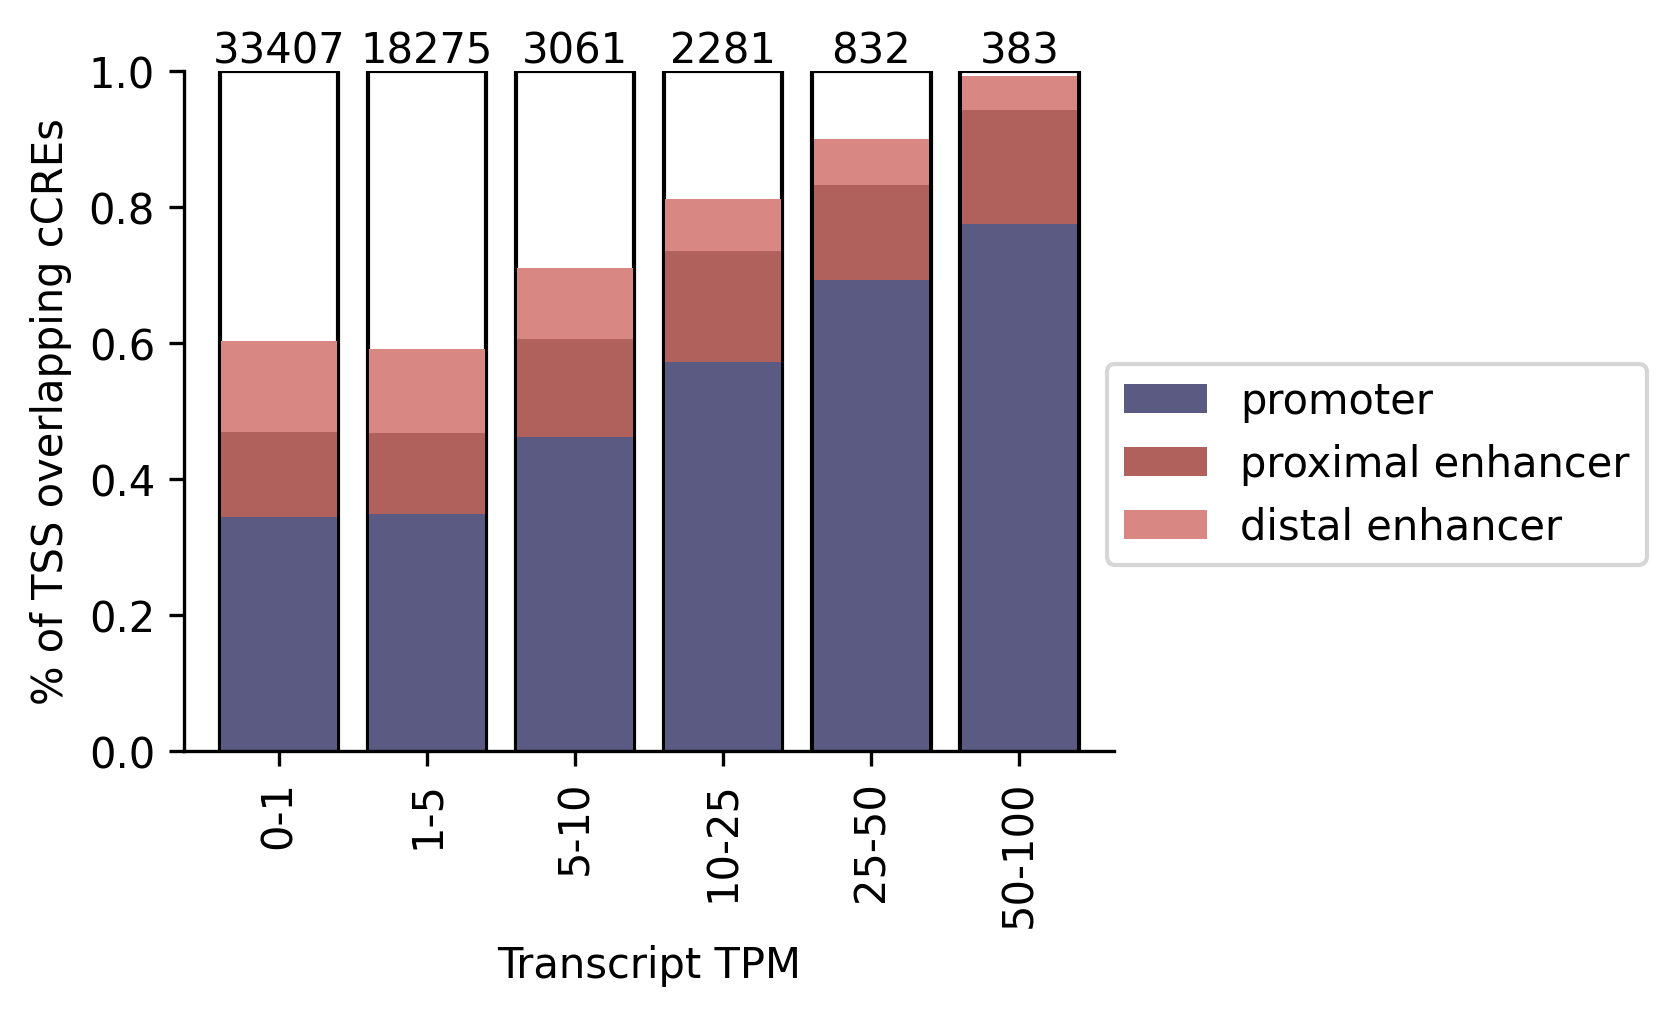

In [109]:
plt.figure(figsize=(4, 3), dpi=300)

plot_percentage_candy_bar(df, 'TPM', 'percentage', 'cCREs', 'total', colors=colors, hue_order=ccres_types)
plt.legend(loc='upper left', bbox_to_anchor=(0.97, 0.6))
plt.xlabel('Transcript TPM')
plt.ylabel('% of TSS overlapping cCREs')

## FANTOM5

In [110]:
df = list()

for lower, upper in tqdm(tpm_filters):
    _transcripts = _transcript_tpm[(upper > _transcript_tpm) & (_transcript_tpm >= lower)].index
    _gr = gr_cor_tss[gr_cor_tss.transcript_id.isin(_transcripts)]

    _gr_fantom = nearest_fantom(_gr, dist=100)
    df.append({
        'TPM': f'{lower}-{upper}',
        '# of TSS': len(_gr_fantom),
        'dataset': 'FANTOM5',
        'total': len(_gr),
        'percentage': len(_gr_fantom) / len(_gr)
     })
    
df = pd.DataFrame(df)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:08<00:00,  1.48s/it]


Text(0, 0.5, '% of TSS overlapping FANTOM5')

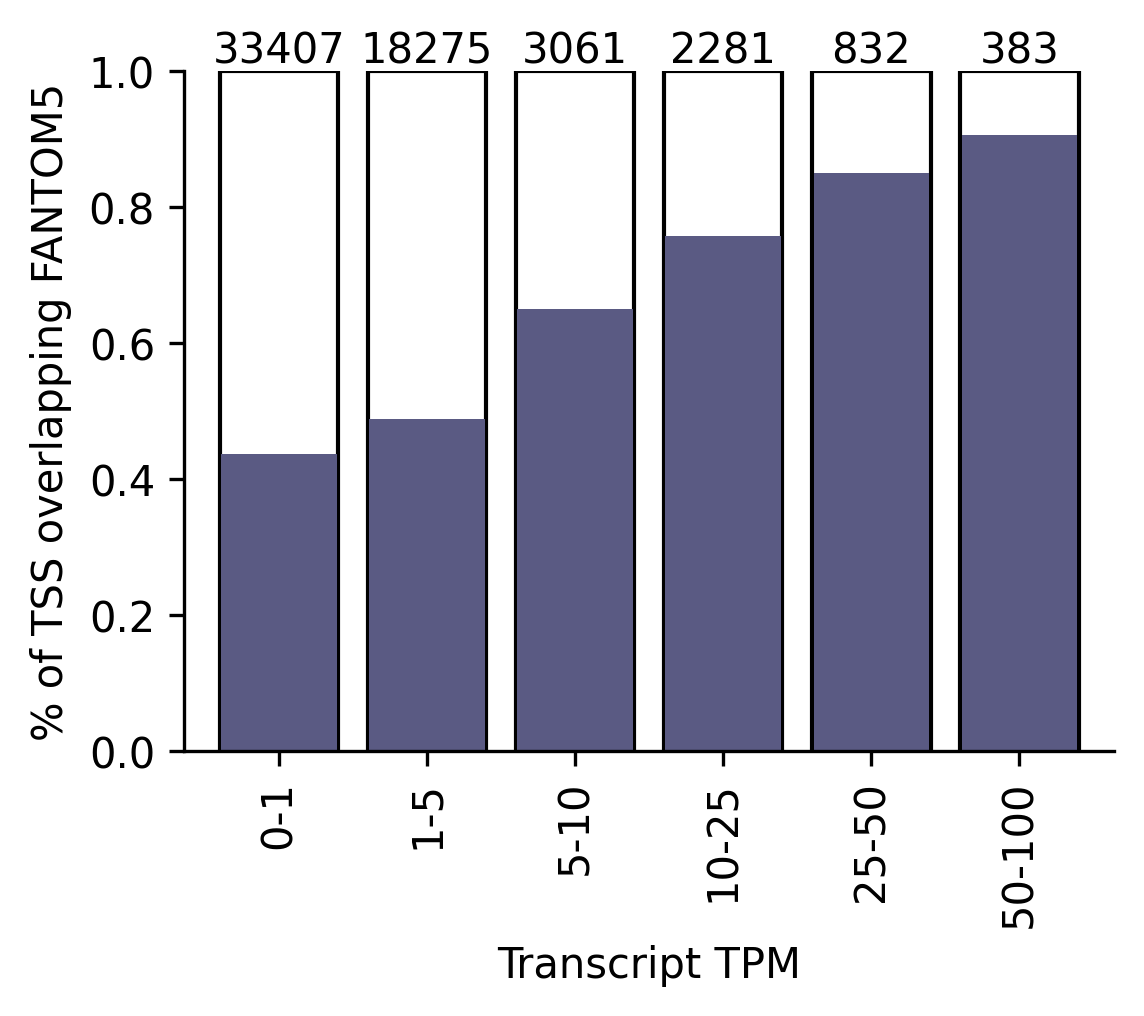

In [114]:
plt.figure(figsize=(4, 3), dpi=300)

ax = plot_percentage_candy_bar(df, 'TPM', 'percentage', 'dataset', 'total', colors=colors)
ax.legend().set_visible(False)
plt.xlabel('Transcript TPM')
plt.ylabel('% of TSS overlapping FANTOM5')

## TSS heatmap

In [167]:
count_tss = df_cor_tss.set_index('transcript_id').join(
    df_abundance.set_index('annot_transcript_id')[samples]).groupby(['tss_site', 'gene_id']).sum()[samples]

In [168]:
count_gene = count_tss.reset_index().groupby('gene_id').sum()

In [169]:
count_gene[count_gene < 20] = 0

In [170]:
usage_tss = count_tss.div(count_gene, level=1).replace(np.inf, np.nan)

In [171]:
usage_dif = (usage_tss.max(axis=1) - usage_tss.min(axis=1)).abs()

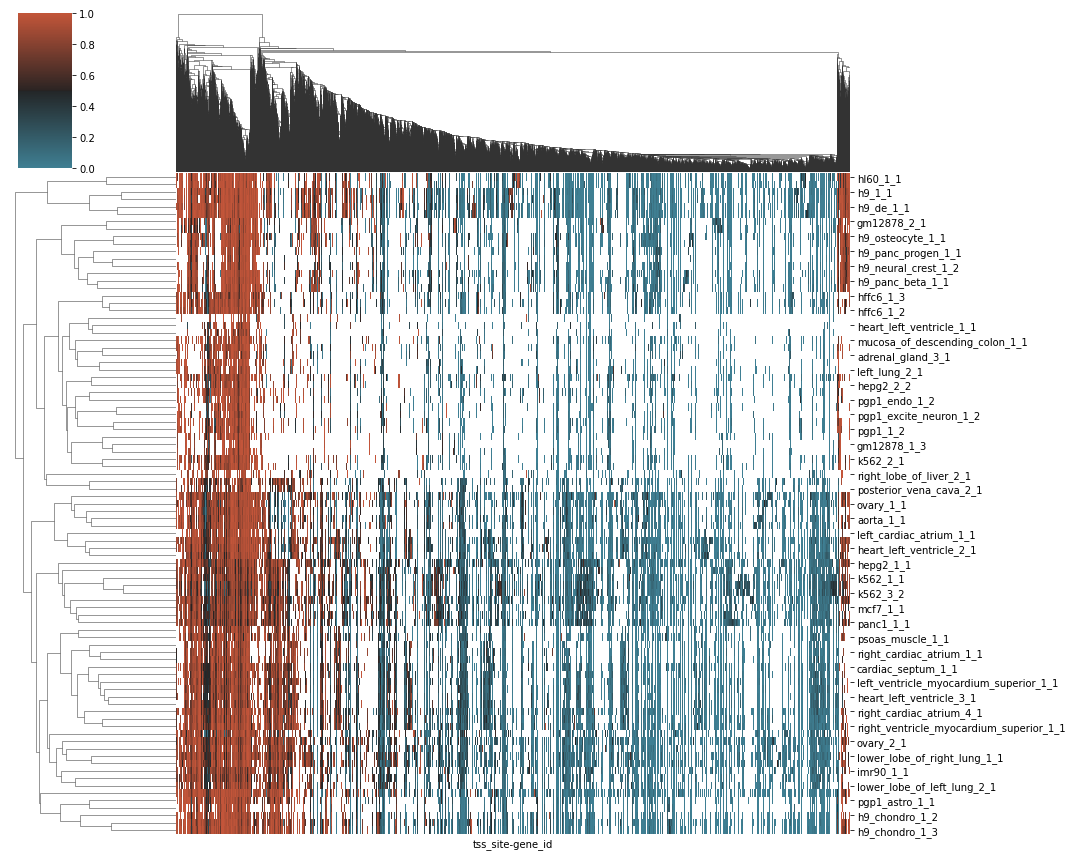

In [172]:
import numpy as np

_usage_tss = usage_tss.loc[usage_dif[usage_dif > 0.2].index].T

cmap = sns.diverging_palette(220, 20, as_cmap=True, center="dark")

sns.clustermap(_usage_tss.fillna(0), mask=_usage_tss.isna(), figsize=(15, 12), 
               xticklabels=False, cmap=cmap)

plt.savefig('reports/wg/figures/tss_heatmap_usage.png', dpi=300, bbox_inches='tight')

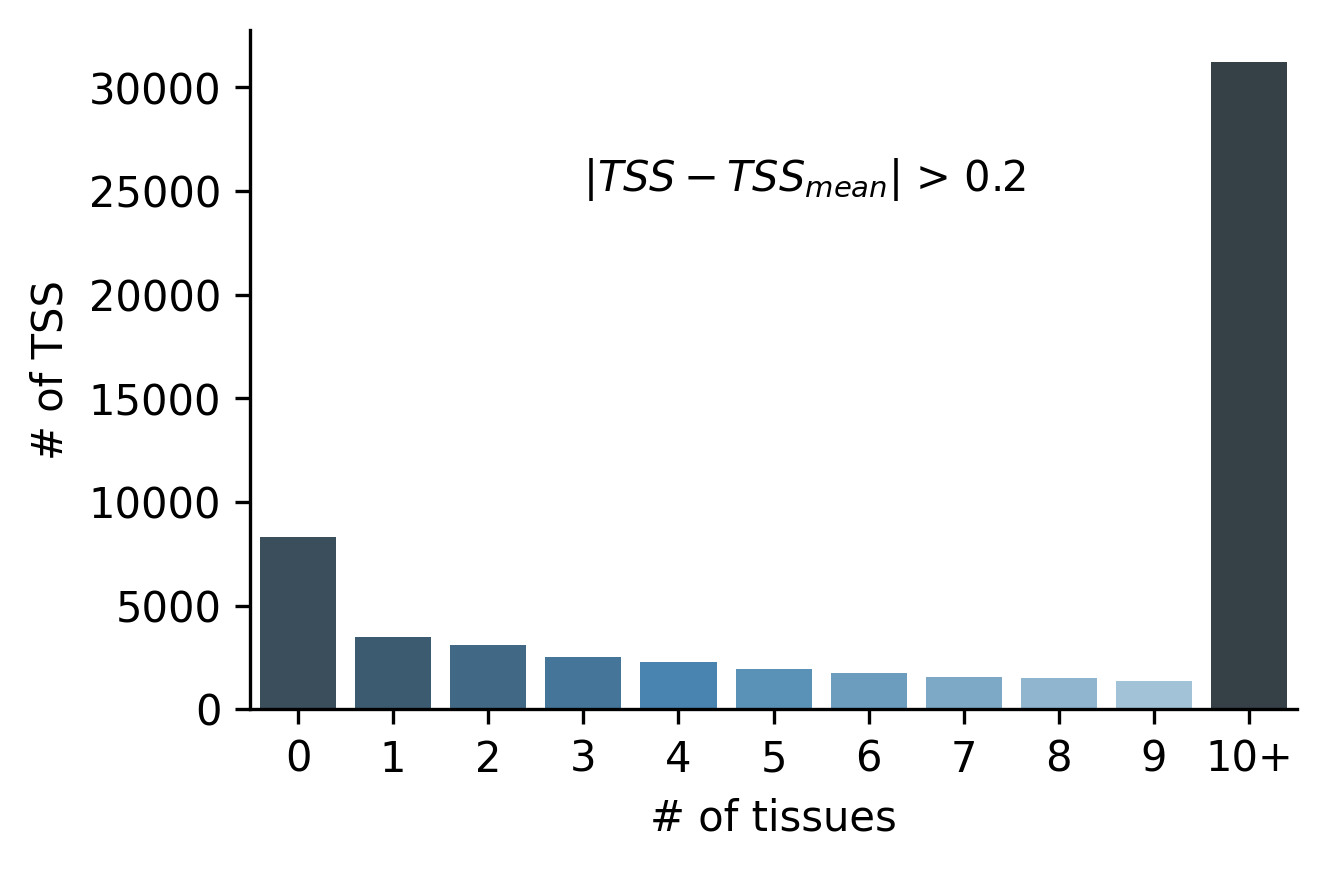

In [173]:
usage_mean_dif = ((usage_tss - usage_tss.mean()).abs() > 0.2).sum(axis=1)

usage_mean_dif_hist_top_n = hist_n_plus(usage_mean_dif, 10).to_frame().reset_index()

plt.figure(figsize=(4.5, 3), dpi=300)
pal = sns.color_palette("Blues_d", len(usage_mean_dif_hist_top_n.index))
rank = usage_mean_dif_hist_top_n[0].argsort().argsort()

sns.barplot(data=usage_mean_dif_hist_top_n, 
            x='index', y=0, palette=np.array(pal)[rank])

plt.text(3, 25000, '$|TSS - TSS_{mean}|$ > 0.2')
plt.xlabel('# of tissues')
plt.ylabel('# of TSS')
ax.legend()
sns.despine()\

# TODO: hexbin x -> number detected tissues, y-> number tissue specific color -> num tss

In [594]:
usage_mean_dif['cdf'] = usage_dif

In [595]:
df_usage_dif = usage_dif.to_frame('dif')

In [596]:
df_usage_dif['CDF'] = df_usage_dif['dif'].rank(method = 'average', pct = True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


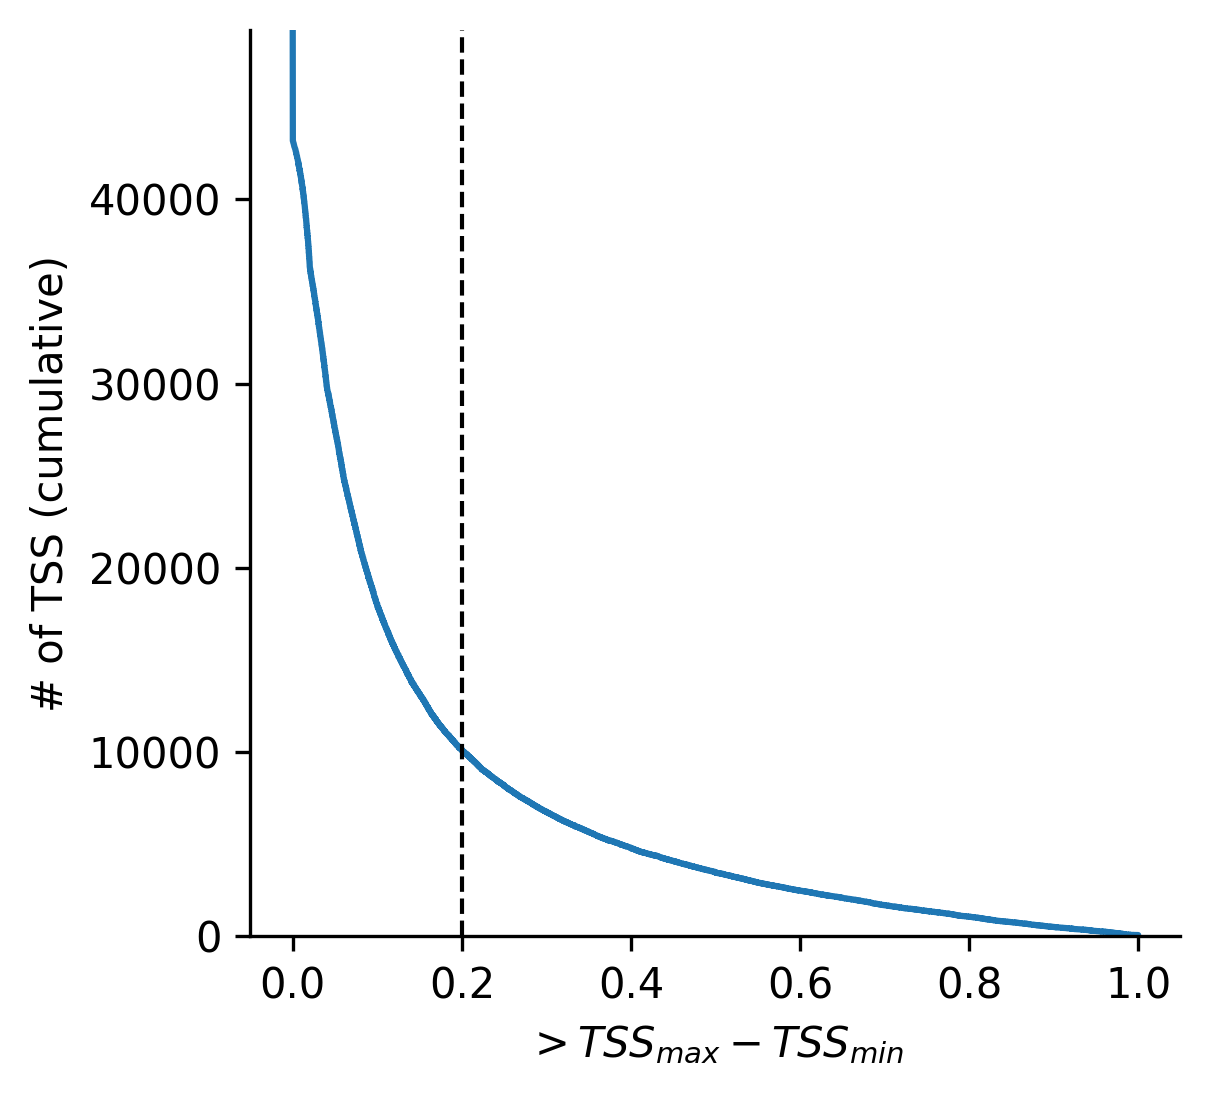

In [597]:
plt.figure(figsize=(4, 4), dpi=300)

sns.ecdfplot(data=df_usage_dif, x="dif", stat='count', complementary=True)
plt.xlabel('$ > TSS_{max} - TSS_{min}$')
plt.ylabel('# of TSS (cumulative)')

plt.axvline(x=0.2, color='k', linestyle='--', linewidth=1)

ax.legend()
sns.despine()

#sns.lineplot(data=df_usage_dif.sort_values('CDF'), x='dif', y='CDF')

In [788]:
_df = (count_tss > 0).groupby(level='gene_id').sum().reset_index().melt(id_vars=['gene_id'])

In [794]:
_df.loc[(_df['value'] > 10) & _df['variable'].str.contains('heart')]

,gene_id,variable,value
904357,ENSG00000005007.12,heart_left_ventricle_4_1,11
904502,ENSG00000008838.19,heart_left_ventricle_4_1,11
904507,ENSG00000009307.15,heart_left_ventricle_4_1,15
904534,ENSG00000010327.10,heart_left_ventricle_4_1,14
904551,ENSG00000011028.13,heart_left_ventricle_4_1,14
...,...,...,...
1022159,ENSG00000204843.12,heart_right_ventricle_2_1,16
1022250,ENSG00000205609.12,heart_right_ventricle_2_1,11
1022618,ENSG00000224389.9,heart_right_ventricle_2_1,15
1022966,ENSG00000244731.7,heart_right_ventricle_2_1,19


In [619]:
usage_tss.groupby(level='gene_id').max().values.ravel()

array([nan, nan, nan, ...,  1.,  1.,  1.])

In [628]:
usage_tss.head().groupby(level='gene_id').apply(lambda x: x.apply(lambda y: y.nlargest(2)))


#.values.ravel()

gm12878_1_2  \
gene_id            tss_site          gene_id                           
ENSG00000107554.16 chr10:100009911:- ENSG00000107554.16          NaN   
ENSG00000107566.13 chr10:100186027:- ENSG00000107566.13          NaN   
                   chr10:100183805:- ENSG00000107566.13          NaN   
ENSG00000120054.11 chr10:100081843:- ENSG00000120054.11          NaN   
ENSG00000213341.10 chr10:100218819:- ENSG00000213341.10          NaN   

                                                         gm12878_1_3  \
gene_id            tss_site          gene_id                           
ENSG00000107554.16 chr10:100009911:- ENSG00000107554.16          NaN   
ENSG00000107566.13 chr10:100186027:- ENSG00000107566.13          NaN   
                   chr10:100183805:- ENSG00000107566.13          NaN   
ENSG00000120054.11 chr10:100081843:- ENSG00000120054.11          NaN   
ENSG00000213341.10 chr10:100218819:- ENSG00000213341.10          NaN   

                                                         gm12878_1_4  \
gene_id            tss_site          gene_id                           
ENSG00000107554.16 chr10:100009911:- ENSG00000107554.16          NaN   
ENSG00000107566.13 chr10:100186027:- ENSG00000107566.13          NaN   
                   chr10:100183805:- ENSG00000107566.13          NaN   
ENSG00000120054.11 chr10:100081843:- ENSG00000120054.11          NaN   
ENSG00000213341.10 chr10:100218819:- ENSG00000213341.10          NaN   

                                                         gm12878_3_1  \
gene_id            tss_site          gene_id                           
ENSG00000107554.16 chr10:100009911:- ENSG00000107554.16          NaN   
ENSG00000107566.13 chr10:100186027:- ENSG00000107566.13     1.000000   
                   chr10:100183805:- ENSG00000107566.13     0.000000   
ENSG00000120054.11 chr10:100081843:- ENSG00000120054.11          NaN   
ENSG00000213341.10 chr10:100218819:- ENSG00000213341.10     0.022222   

                                                         gm12878_2_1  \
gene_id            tss_site          gene_id                           
ENSG00000107554.16 chr10:100009911:- ENSG00000107554.16          NaN   
ENSG00000107566.13 chr10:100186027:- ENSG00000107566.13          1.0   
                   chr10:100183805:- ENSG00000107566.13          0.0   
ENSG00000120054.11 chr10:100081843:- ENSG00000120054.11          NaN   
ENSG00000213341.10 chr10:100218819:- ENSG00000213341.10          NaN   

                                                         gm12878_2_2  \
gene_id            tss_site          gene_id                           
ENSG00000107554.16 chr10:100009911:- ENSG00000107554.16          NaN   
ENSG00000107566.13 chr10:100186027:- ENSG00000107566.13     0.962963   
                   chr10:100183805:- ENSG00000107566.13     0.037037   
ENSG00000120054.11 chr10:100081843:- ENSG00000120054.11          NaN   
ENSG00000213341.10 chr10:100218819:- ENSG00000213341.10          NaN   

                                                         pgp1_1_1  pgp1_1_2  \
gene_id            tss_site          gene_id                                  
ENSG00000107554.16 chr10:100009911:- ENSG00000107554.16       NaN       NaN   
ENSG00000107566.13 chr10:100186027:- ENSG00000107566.13       NaN       NaN   
                   chr10:100183805:- ENSG00000107566.13       NaN       NaN   
ENSG00000120054.11 chr10:100081843:- ENSG00000120054.11       NaN       NaN   
ENSG00000213341.10 chr10:100218819:- ENSG00000213341.10       NaN       NaN   

                                                         h9_1_1    h9_1_2  \
gene_id            tss_site          gene_id                                
ENSG00000107554.16 chr10:100009911:- ENSG00000107554.16     NaN       NaN   
ENSG00000107566.13 chr10:100186027:- ENSG00000107566.13     1.0  0.996109   
                   chr10:100183805:- ENSG00000107566.13     0.0  0.003891   
ENSG00000120054.11 chr10:100081843:- ENSG00000120054.11     NaN       NaN   
ENSG0000021

In [636]:
usage_tss['gm12878_1_2'].nlargest(10, keep='first')

tss_site           gene_id           
chr10:100987473:-  ENSG00000055950.16    1.0
chr10:102502711:-  ENSG00000138107.12    1.0
chr10:103918183:-  ENSG00000107960.10    1.0
chr10:104254902:+  ENSG00000148834.12    1.0
chr10:119542703:-  ENSG00000148908.14    1.0
chr10:12195889:-   ENSG00000165609.12    1.0
chr10:124418921:-  ENSG00000065154.11    1.0
chr10:125823548:+  ENSG00000107949.16    1.0
chr10:130136400:+  ENSG00000108010.11    1.0
chr10:131981922:-  ENSG00000176171.11    1.0
Name: gm12878_1_2, dtype: float64

In [634]:
usage_tss['gm12878_1_2'].max()

1.0

In [743]:
gene_nums = usage_tss.groupby(level='gene_id').size()
usage_tss_multi = usage_tss[usage_tss.reset_index()['gene_id'].isin(gene_nums[gene_nums > 1].index).tolist()]

In [760]:
usage_ranked = list()

for i, df in tqdm(usage_tss_multi.groupby(level='gene_id')):
    for _, usage in df.iteritems():
        if not usage.isna().all():
            top_n = 3
            usage = np.sort(usage)[::-1][:top_n]
            usage = np.pad(usage, (0, top_n - len(usage)))
            usage_ranked.append(usage)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11850/11850 [02:36<00:00, 75.85it/s]


In [761]:
usage_tss

,,gm12878_1_2,gm12878_1_3,gm12878_1_4,gm12878_3_1,gm12878_2_1,gm12878_2_2,pgp1_1_1,pgp1_1_2,h9_1_1,h9_1_2,...,psoas_muscle_1_1,right_cardiac_atrium_1_1,right_cardiac_atrium_3_1,right_cardiac_atrium_4_1,right_cardiac_atrium_2_1,right_lobe_of_liver_1_1,right_lobe_of_liver_2_1,right_ventricle_myocardium_inferior_1_1,right_ventricle_myocardium_superior_1_1,upper_lobe_of_right_lung_1_1
tss_site,gene_id,,,,,,,,,,,,,,,,,,,,,
chr10:100009911:-,ENSG00000107554.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chr10:100081843:-,ENSG00000120054.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
chr10:100183805:-,ENSG00000107566.13,NaN,NaN,NaN,0.000000,0.0,0.037037,NaN,NaN,0.0,0.003891,...,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.045455,0.0
chr10:100186027:-,ENSG00000107566.13,NaN,NaN,NaN,1.000000,1.0,0.962963,NaN,NaN,1.0,0.996109,...,1.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,0.954545,1.0
chr10:100218819:-,ENSG00000213341.10,NaN,NaN,NaN,0.022222,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrY:2935389:+,ENSG00000067646.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chrY:2978027:+,ENSG00000067646.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chrY:2979080:+,ENSG00000067646.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


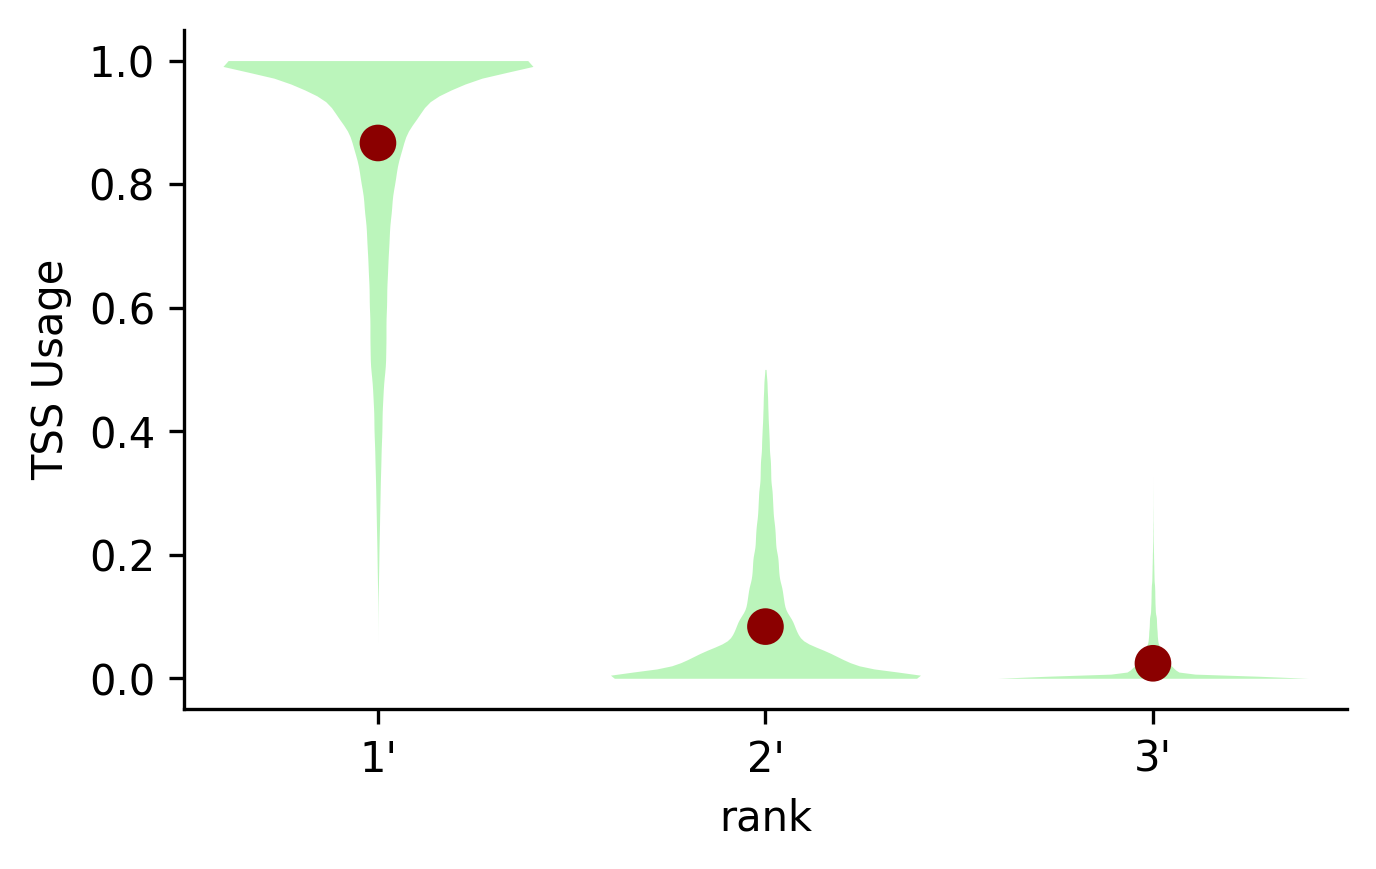

In [775]:
plt.figure(figsize=(5, 3), dpi=300)

df_usage_ranked = pd.DataFrame(np.array(usage_ranked)).melt(var_name='rank', value_name='usage')
df_usage_ranked['rank'] = (df_usage_ranked['rank'] + 1).astype('str') + "'"

ax = sns.violinplot(data=df_usage_ranked, x='rank', y='usage', cut=0, scale="count", linewidth=0,
               inner=None, color='lime', alpha=0.5)

for violin in ax.collections:
    violin.set_alpha(0.3)

sns.pointplot(x='rank', y='usage', data=df_usage_ranked, join=False, color='darkred')

plt.ylabel('TSS Usage')

sns.despine()